In [118]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import root
from scipy.signal import find_peaks
import pickle

plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rc('font', family='serif')

In [106]:
F = 50
gamma = 0.1
I_i = np.linspace(0,40,1000)
delta = np.linspace(0, 1,1000)
T = 1 / (1 + F * np.sin(delta + gamma * I_i)**2)

I_0_arr = np.linspace(1,40,1000)
R = 0.85
T2_vals = []

for I_0 in I_0_arr:
    T2 = (1-R)/(1+R) * (I_i / I_0)
    T2_vals.append(T2)
    
T = 1 / (1 + F * np.sin(delta + gamma * I_i)**2)

Let's try and solve this graphically instead


\begin{equation}
T = \frac{1}{1 + F \sin^2(\delta_0 + \gamma I_i)} \tag{1}
\end{equation}

\begin{equation}
T = \frac{(1 - R)}{1 + R } \frac{I_i}{I_o}\tag{2}
\end{equation}

In [107]:
I_0_arr = np.linspace(1,40,1000)
R = 0.85
T2_vals = []

for I_0 in I_0_arr:
    T2 = (1-R)/(1+R) * (I_i / I_0)
    T2_vals.append(T2)
        
T = 1 / (1 + F * np.sin(delta + gamma * I_i)**2)

In [108]:
I_0_dict_arr = []
for idx, I_0 in enumerate(I_0_arr):
    T2_line = T2_vals[idx]
    peaks, _ = find_peaks(-np.abs(T - T2_vals[idx]))
    filtered_peaks = []
    for peak in peaks:
        if np.abs(T - T2_vals[idx])[peak] < 0.01:
            filtered_peaks.append(peak)
    T_match = T[filtered_peaks]
    I_0_dict_arr.append({"I_0": I_0, "peaks": filtered_peaks, "T_match": T_match})


In [109]:
input_intensities = []
output_intensities = []
for I_0_dict in I_0_dict_arr:
    if len(I_0_dict["peaks"]) > 0:
        T_match = I_0_dict["T_match"]
        for T in T_match:
            input_intensities.append(I_0_dict["I_0"])
            output_intensities.append(T* I_0_dict["I_0"])

Text(0, 0.5, 'Output intensity (a.u)')

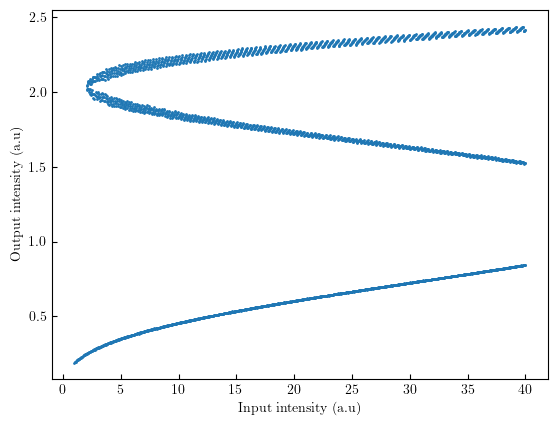

In [110]:
plt.scatter(input_intensities, output_intensities, s=1)
plt.xlabel("Input intensity (a.u)")
plt.ylabel("Output intensity (a.u)")

Let's now try and scan some parameters (fix bug to remove T > 1)

In [111]:
F = 50
GAMMA = 0.1
I_i = np.linspace(0,40,1000)
DELTA = np.linspace(0, 1,1000)

def compute_bistable_curve(finesse, R, gamma):
    I_0_arr = np.linspace(1,40,1000)
    R = 0.85
    T2_vals = []

    for I_0 in I_0_arr:
        T2 = (1-R)/(1+R) * (I_i / I_0)
        T2_vals.append(T2)
            
    T = 1 / (1 + finesse * np.sin(delta + gamma * I_i)**2)
    I_0_arr = np.linspace(1,40,1000)

    I_0_dict_arr = []
    for idx, I_0 in enumerate(I_0_arr):
        peaks, _ = find_peaks(-np.abs(T - T2_vals[idx]))
        filtered_peaks = []
        for peak in peaks:
            if np.abs(T - T2_vals[idx])[peak] < 0.01 and T[peak] < 1:
                filtered_peaks.append(peak)
        T_match = T[filtered_peaks]
        I_0_dict_arr.append({"I_0": I_0, "peaks": filtered_peaks, "T_match": T_match})

    input_intensities = []
    output_intensities = []
    for I_0_dict in I_0_dict_arr:
        if len(I_0_dict["peaks"]) > 0:
            T_match = I_0_dict["T_match"]
            for T in T_match:
                input_intensities.append(I_0_dict["I_0"])
                output_intensities.append(T* I_0_dict["I_0"])

    return input_intensities, output_intensities

scan R: low sensitivity to reflectivity and transmission. changing reflectivity will couple onto finesse. I will assume lossless mirrors. 

\begin{equation}
F_c = \frac{2 \pi}{-\ln{R_1 R_2}}
\end{equation}

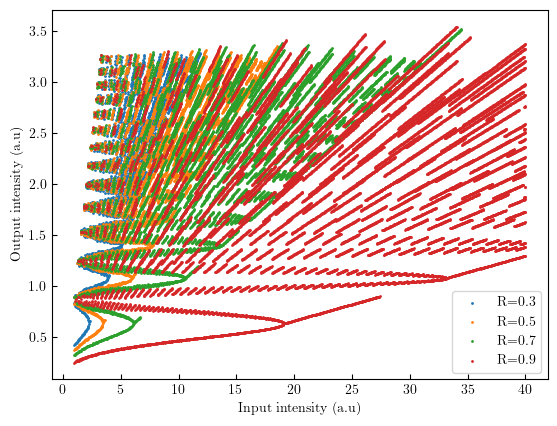

In [112]:
for R in [0.3, 0.5, 0.7, 0.9]:
    finesse = 2 * np.pi / (-np.log(R**2))
    inputs, outputs = compute_bistable_curve(finesse, R, np.linspace(0, 1,1000))
    plt.scatter(inputs, outputs, s=1, label=f"R={R}")
    plt.xlabel("Input intensity (a.u)")
    plt.ylabel("Output intensity (a.u)")
    plt.legend()

plt.show()

ok great we have some sensitivity (some weird numerics tho). However, it looks like only very low reflectivities yield curves that are useful for us unfortunately. Let's fix reflectivity and play with the index of the media. This will be related to effectively stepping $\gamma$ in different increments. Let's just examine some basic scaling behaviors and not worry too much about actual materials.

$\gamma = \frac{4 \pi}{\lambda} n_2 L$


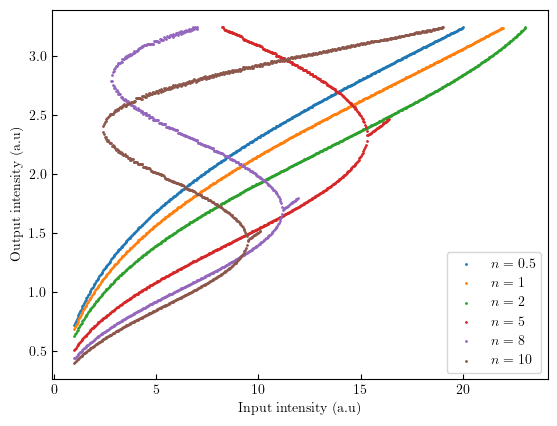

In [113]:
index_arr = [0.5, 1, 2, 5, 8, 10]
for index in index_arr:
    R = 0.6
    finesse = 2 * np.pi / (-np.log(R**2))
    gamma = 4 * np.pi / (1550 * 10**-9) * index * 10**-9
    inputs, outputs = compute_bistable_curve(finesse, R, gamma)
    # truncate gamma sig figs in label
    plt.scatter(inputs, outputs, s=1, label=f"$n = {index}$")
    plt.xlabel("Input intensity (a.u)")
    plt.ylabel("Output intensity (a.u)")
    plt.legend()

plt.show()

Let's try and add a detuning in the form of an additional accumulated round trip phase $2 \pi * \text{normalized detuning}$

In [130]:
def compute_bistable_curve_detuned(R, detuning, n0, n2):
    I_0_arr = np.linspace(1,100,1000)
    R = 0.85
    c = 3 * 10**8 # m/s
    L = 2e-9
    wavelength = 1550 * 10**-9 # m/s

    roundtrip_phase = 2 * np.pi * detuning
    finesse = 2 * np.pi / (-np.log(R**2))
    total_phase = roundtrip_phase + (4*np.pi * L / wavelength) * (n0 + n2 * I_i)

    T2_vals = []

    for I_0 in I_0_arr:
        T2 = (1-R)/(1+R) * (I_i / I_0)
        T2_vals.append(T2)
            
    T = 1 / (1 + finesse * np.sin(total_phase / 2)**2)
    I_0_arr = np.linspace(1,40,1000)

    I_0_dict_arr = []
    for idx, I_0 in enumerate(I_0_arr):
        peaks, _ = find_peaks(-np.abs(T - T2_vals[idx]))
        filtered_peaks = []
        for peak in peaks:
            if np.abs(T - T2_vals[idx])[peak] < 0.01 and T[peak] < 1:
                filtered_peaks.append(peak)
        T_match = T[filtered_peaks]
        I_0_dict_arr.append({"I_0": I_0, "peaks": filtered_peaks, "T_match": T_match})

    input_intensities = []
    output_intensities = []
    for I_0_dict in I_0_dict_arr:
        if len(I_0_dict["peaks"]) > 0:
            T_match = I_0_dict["T_match"]
            for T in T_match:
                input_intensities.append(I_0_dict["I_0"])
                output_intensities.append(T* I_0_dict["I_0"])

    return input_intensities, output_intensities

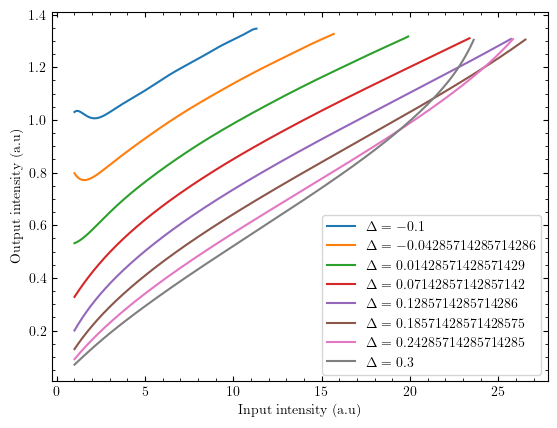

In [ ]:

R = 0.95
detuning_arr = np.linspace(-0.1, 0.3, 8)
for detuning in detuning_arr:
    inputs, outputs = compute_bistable_curve_detuned(R, detuning, 1, 3)
    p = np.polyfit(inputs, outputs, 10)
    plt.plot(inputs, np.polyval(p, inputs), label=f"$\Delta = {detuning}$")
    with open("polyfit_" + str(detuning) + ".pkl", "wb") as f:
        pickle.dump(p, f)
    # plt.scatter(inputs, outputs, s=3, label=f"$\Delta = {detuning}$")
    plt.xlabel("Input intensity (a.u)")
    plt.tick_params(top=True, right=True, which='both')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major')
    plt.tick_params(axis='both', which='minor')
    plt.ylabel("Output intensity (a.u)")
    # plt.xlim(0, 50)
    # plt.savefig("scan_detuning.png", dpi=300)
    plt.legend()

ok not good - let's try higher order polynomial

[-5.01954137e-14  1.09973841e-11 -1.04550977e-09  5.65764901e-08
 -1.92230632e-06  4.27158947e-05 -6.28594048e-04  6.10817527e-03
 -3.92476993e-02  1.94237848e-01  1.90088097e-01]


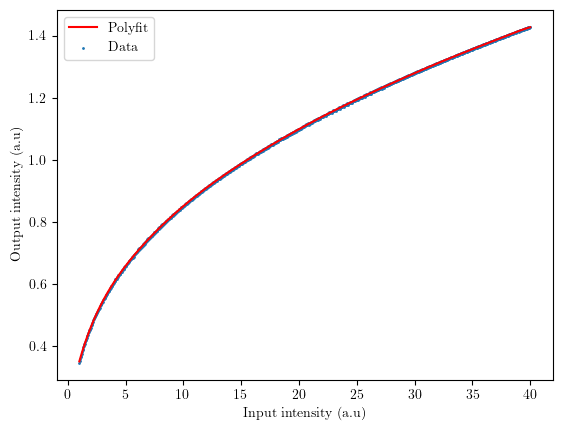

In [122]:
# high order polynomial fit
p = np.polyfit(inputs, outputs, 10)
plt.plot(inputs, np.polyval(p, inputs), label="Polyfit", color = 'red')
plt.scatter(inputs, outputs, s=1, label="Data")
plt.xlabel("Input intensity (a.u)")
plt.ylabel("Output intensity (a.u)")
plt.legend()

# extract fit params
print(p)
# store polynomial coefficients as pickle
import pickle
with open("polyfit.pkl", "wb") as f:
    pickle.dump(p, f)

ok then... let's try a function that is of form: 
\begin{align}
y &= -5.01954137^{-14} x^{10} + 1.09973841^{-11} x^{9} \\
    &+  -1.04550977^{-9} x^{8}+ 5.65764901^{-8} x^{7} \\
    & -1.92230632^{6} x^6 +  4.27158947^{-5}x^5 \\
    &-6.28594048^{-4}x^4  + 6.10817527^{-3}x^3\\
    &-3.92476993^{-2}x^2  +1.94237848^{-1}x  +0.190088097
 \end{align}

In [32]:
def compute_bistable_detuned_lossy(R, detuning, lossiness):
    n0 = 1
    n2 = 4
    I_0_arr = np.linspace(1,40,1000)
    R = 0.85
    c = 3 * 10**8 # m/s
    L = 2e-9
    wavelength = 1550 * 10**-9 # m/s

    roundtrip_phase = 2 * np.pi * detuning
    finesse = 2 * np.pi / (-np.log(R**2))
    total_phase = roundtrip_phase + (4*np.pi * L / wavelength) * (n0 + n2 * I_i)
    
    T2_vals = []

    for I_0 in I_0_arr:
        T2 = (1-R)/(1+R) * (I_i / I_0)
        T2_vals.append(T2)
            
    T = 1 / (1 + finesse * np.sin(total_phase + lossiness * total_phase/ 2)**2)
    I_0_arr = np.linspace(1,40,1000)

    I_0_dict_arr = []
    for idx, I_0 in enumerate(I_0_arr):
        peaks, _ = find_peaks(-np.abs(T - T2_vals[idx]))
        filtered_peaks = []
        for peak in peaks:
            if np.abs(T - T2_vals[idx])[peak] < 0.01 and T[peak] < 1:
                filtered_peaks.append(peak)
        T_match = T[filtered_peaks]
        I_0_dict_arr.append({"I_0": I_0, "peaks": filtered_peaks, "T_match": T_match})

    input_intensities = []
    output_intensities = []
    for I_0_dict in I_0_dict_arr:
        if len(I_0_dict["peaks"]) > 0:
            T_match = I_0_dict["T_match"]
            for T in T_match:
                input_intensities.append(I_0_dict["I_0"])
                output_intensities.append(T* I_0_dict["I_0"])

    return input_intensities, output_intensities

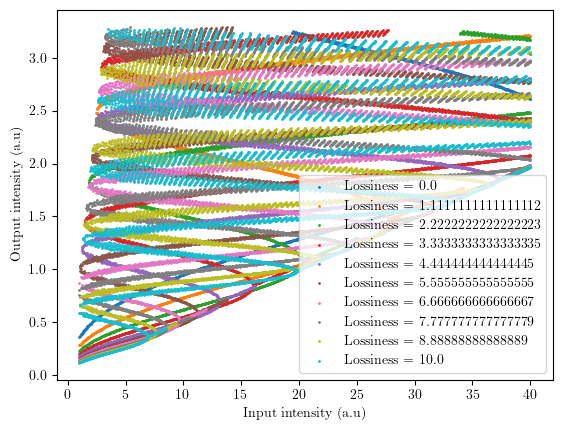

In [37]:
losses = np.linspace(0, 10,10)
for loss in losses:
    inputs, outputs = compute_bistable_detuned_lossy(R, 0, loss)
    plt.scatter(inputs, outputs, s=1, label=f"Lossiness = {loss}")
    plt.xlabel("Input intensity (a.u)")
    plt.ylabel("Output intensity (a.u)")
    plt.legend()

so it looks like the inclusion of loss pushes the bistable region to smaller and smaller intensities